# Demo - Using `alchemiscale` to evaluate a relative binding free energy network

This notebook details the process of running a relative binding free energy calculation using the [openfe](https://github.com/OpenFreeEnergy/openfe/) toolkit and the execution platform [alchemiscale](https://github.com/openforcefield/alchemiscale).

The notebook is broken down into the following section:
  1. Creating an `AlchemicalNetwork`
  2. Submitting an `Alchemicalnetwork` to `alchemiscale`
  3. Monitoring the progress of an `alchemiscale` submission
  4. Gathering results and analyzing them using `cinnabar`

## Creating an `AlchemicalNetwork` for the `tyk2` benchmark system

We first illustrate how to build `AlchemicalNetwork` objects,
from a starting point of chemical models stored in sdf and pdb files.

An `AlchemicalNetwork` is used to represent an entire network of calculations,
and is composed of many smaller objects:

- An `AlchemicalNetwork` composed of 
  - each node a `ChemicalSystem`
    - each containing many components, such as `SmallMoleculeComponent`, `ProteinComponent`
      - internally each Component usually wraps an RDKit representation
  - each directed edge a `Transformation`, containing
    - two `ChemicalSystem`s, the 'A' and 'B' side
    - zero or more `Mapping` objects relating these two sides
    - a `Protocol` defining the computational method to be applied to other items

In [1]:
# suppress `numba` warnings, if present
from numba.core.errors import NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaWarning)

In [2]:
import openfe
from gufe import AlchemicalNetwork
from openff.units import unit
from rdkit import Chem

LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


### Define `ChemicalSystem`s for network nodes

We'll start by defining the nodes for our network.
A `ChemicalSystem` is made of one or more `Component`s. These can be one of `ProteinComponent`, `SmallMoleculeComponent`, or `SolventComponent`, and potentially others as needed. This design allows for memory efficient representation of large networks with perhaps hundreds or thousands of nodes, but perhaps far fewer variants in proteins, ligands, etc.

#### Reading Ligands

The ligands are concatenated in a single sdf file, we'll read these using RDKit.

Each of the ligands have been pre-docked into the protein and aligned to their common scaffold. It is important to recognize that any processing required to prepare ligand and protein structures for alchemical free energy calculations should be done *before* the steps we are taking here.

In [3]:
ligands = [
    openfe.SmallMoleculeComponent(m) for m in Chem.SDMolSupplier('ligands.sdf', removeHs=False)
]
ligands

[SmallMoleculeComponent(name=lig_ejm_54),
 SmallMoleculeComponent(name=lig_jmc_23),
 SmallMoleculeComponent(name=lig_ejm_47),
 SmallMoleculeComponent(name=lig_jmc_27),
 SmallMoleculeComponent(name=lig_ejm_46),
 SmallMoleculeComponent(name=lig_ejm_31),
 SmallMoleculeComponent(name=lig_ejm_42),
 SmallMoleculeComponent(name=lig_ejm_50),
 SmallMoleculeComponent(name=lig_ejm_45),
 SmallMoleculeComponent(name=lig_jmc_28),
 SmallMoleculeComponent(name=lig_ejm_55),
 SmallMoleculeComponent(name=lig_ejm_43),
 SmallMoleculeComponent(name=lig_ejm_48)]

In [4]:
# The OpenFE RBFE protocol does not yet support charge changes (to be changed very soon!)
# Here we raise an error if a change in formal charge is identified
base_formalcharge = Chem.rdmolops.GetFormalCharge(ligands[0].to_rdkit())

for mol in ligands[1:]:
    if Chem.rdmolops.GetFormalCharge(mol.to_rdkit()) != base_formalcharge:
        errmsg = f"The molecule {mol} has a different formal charge than the first ligand molecule"
        raise ValueError(errmsg)

#### Reading the protein

The protein is supplied as a PDB file, readable via the `ProteinComponent.from_pdb_file` class method.

In [5]:
protein = openfe.ProteinComponent.from_pdb_file('protein.pdb', name='tyk2')
protein

ProteinComponent(name=tyk2)

#### Defining the solvent

We'll also need at least one `SolventComponent` to encode our choice of solvent and counterions, with concentration.
The concentration is defined as having units supplied by `openff.units`, this package is used to avoid confusion.


The `SolventComponent` doesn't actually perform any actual solvation (packing water molecules, ions); that is performed just before simulation time during `Protocol` execution.

In [6]:
solvent = openfe.SolventComponent(positive_ion='Na', 
                                  negative_ion='Cl',
                                  neutralize=True, 
                                  ion_concentration=0.15*unit.molar)
solvent

SolventComponent(name=O, Na+, Cl-)

#### Build the `ChemicalSystem`s

We can now construct the `ChemicalSystem`s we want represented in our network. Since we are planning to perform relative binding free energy (RBFE) calculations, we'll define both *complex* and *solvent* variants for each ligand.

This produces a dictionary mapping the ligand name to the `ChemicalSystem` that contains that ligand.
There are two dictionaries, for complexed and solvated ligands respectively.

In [7]:
complexed = {l.name: openfe.ChemicalSystem(components={'ligand': l,
                                                       'solvent': solvent, 
                                                       'protein': protein}, 
                                           name=f"{l.name}_complex") 
             for l in ligands}
complexed

{'lig_ejm_54': ChemicalSystem(name=lig_ejm_54_complex, components={'ligand': SmallMoleculeComponent(name=lig_ejm_54), 'solvent': SolventComponent(name=O, Na+, Cl-), 'protein': ProteinComponent(name=tyk2)}),
 'lig_jmc_23': ChemicalSystem(name=lig_jmc_23_complex, components={'ligand': SmallMoleculeComponent(name=lig_jmc_23), 'solvent': SolventComponent(name=O, Na+, Cl-), 'protein': ProteinComponent(name=tyk2)}),
 'lig_ejm_47': ChemicalSystem(name=lig_ejm_47_complex, components={'ligand': SmallMoleculeComponent(name=lig_ejm_47), 'solvent': SolventComponent(name=O, Na+, Cl-), 'protein': ProteinComponent(name=tyk2)}),
 'lig_jmc_27': ChemicalSystem(name=lig_jmc_27_complex, components={'ligand': SmallMoleculeComponent(name=lig_jmc_27), 'solvent': SolventComponent(name=O, Na+, Cl-), 'protein': ProteinComponent(name=tyk2)}),
 'lig_ejm_46': ChemicalSystem(name=lig_ejm_46_complex, components={'ligand': SmallMoleculeComponent(name=lig_ejm_46), 'solvent': SolventComponent(name=O, Na+, Cl-), 'protei

In [8]:
solvated = {l.name: openfe.ChemicalSystem(components={'ligand': l, 
                                                      'solvent': solvent}, 
                                          name=f"{l.name}_solvent") 
            for l in ligands}
solvated

{'lig_ejm_54': ChemicalSystem(name=lig_ejm_54_solvent, components={'ligand': SmallMoleculeComponent(name=lig_ejm_54), 'solvent': SolventComponent(name=O, Na+, Cl-)}),
 'lig_jmc_23': ChemicalSystem(name=lig_jmc_23_solvent, components={'ligand': SmallMoleculeComponent(name=lig_jmc_23), 'solvent': SolventComponent(name=O, Na+, Cl-)}),
 'lig_ejm_47': ChemicalSystem(name=lig_ejm_47_solvent, components={'ligand': SmallMoleculeComponent(name=lig_ejm_47), 'solvent': SolventComponent(name=O, Na+, Cl-)}),
 'lig_jmc_27': ChemicalSystem(name=lig_jmc_27_solvent, components={'ligand': SmallMoleculeComponent(name=lig_jmc_27), 'solvent': SolventComponent(name=O, Na+, Cl-)}),
 'lig_ejm_46': ChemicalSystem(name=lig_ejm_46_solvent, components={'ligand': SmallMoleculeComponent(name=lig_ejm_46), 'solvent': SolventComponent(name=O, Na+, Cl-)}),
 'lig_ejm_31': ChemicalSystem(name=lig_ejm_31_solvent, components={'ligand': SmallMoleculeComponent(name=lig_ejm_31), 'solvent': SolventComponent(name=O, Na+, Cl-)})

### Define `Transformation`s between `ChemicalSystem`s as network edges

A `Transformation` is a directed edge between two `ChemicalSystem`s. It includes a `Protocol` parameterized with `Settings`, and optionally a `ComponentMapping`. 

The `Protocol` defines the actual computational method used to evaluate the `Transformation` to yield estimates for the free energy difference between the `ChemicalSystem`s.

The `ComponentMapping` defines the atom mapping(s) between corresponding `Component`s in the two `ChemicalSystem`s. This is often critical for relative binding free energy calculations, since the choice of mapping can heavily influence convergence of the resulting estimates.

#### Define the `Protocol` used for `Transformation` evaluation

For this example, we'll use the same `Protocol` for all our `Transformation`s, with identical `Settings` for each.

In [9]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol

Any given `Protocol` has a `default_settings()` method, which can be used to get the default settings that are specific to that `Protocol`:

In [10]:
protocol_settings = RelativeHybridTopologyProtocol.default_settings()
protocol_settings.dict()

{'forcefield_settings': {'constraints': 'hbonds',
  'rigid_water': True,
  'remove_com': False,
  'hydrogen_mass': 3.0,
  'forcefields': ['amber/ff14SB.xml',
   'amber/tip3p_standard.xml',
   'amber/tip3p_HFE_multivalent.xml',
   'amber/phosaa10.xml'],
  'small_molecule_forcefield': 'openff-2.0.0'},
 'thermo_settings': {'temperature': 298.15 <Unit('kelvin')>,
  'pressure': 0.9869232667160129 <Unit('standard_atmosphere')>,
  'ph': None,
  'redox_potential': None},
 'system_settings': {'nonbonded_method': 'PME',
  'nonbonded_cutoff': 1.0 <Unit('nanometer')>},
 'solvation_settings': {'solvent_model': 'tip3p',
  'solvent_padding': 1.2 <Unit('nanometer')>},
 'alchemical_settings': {'lambda_functions': 'default',
  'lambda_windows': 11,
  'unsampled_endstates': False,
  'use_dispersion_correction': False,
  'softcore_LJ_v2': True,
  'softcore_electrostatics': True,
  'softcore_alpha': 0.85,
  'softcore_electrostatics_alpha': 0.3,
  'softcore_sigma_Q': 1.0,
  'interpolate_old_and_new_14s': Fa

In [11]:
# Here we make it so that each simulation only encompasses a single repeat
# We then do multiple repeats by running each simulation multiple time
protocol_settings.alchemical_sampler_settings.n_repeats = 1

# We enforce the compute platform to be CUDA. This ensures that a bad GPU node
# on alchemiscale will fail automatically rather than trying to defaul to the CPU kernels
protocol_settings.engine_settings.compute_platform = "CUDA"

# We set the protocol to auto terminate once the error drops below 0.2 kT
protocol_settings.alchemical_sampler_settings.online_analysis_target_error = 0.2 * unit.boltzmann_constant * unit.kelvin

We can now produce a parameterized `RelativeHybridTopologyProtocol` instance:

In [13]:
protocol = RelativeHybridTopologyProtocol(protocol_settings)

#### Build the `Transformation`s

We can now construct the `Transformation`s we want represented in our network.

We'll use `openfe`'s implementation of the `LomapAtomMapper` to produce mappings between ligands, the default LOMAP scorer for assessing the quality of the mappings produced, and the minimal spanning tree network planner. However, you could use any network planner of your choice to generate the network connections and mappings and use those instead.

In [14]:
mapper = openfe.LomapAtomMapper(max3d=1.0, element_change=True)
scorer = openfe.lomap_scorers.default_lomap_score
network_planner = openfe.ligand_network_planning.generate_minimal_spanning_network

In [15]:
# Note creating a minimum spanning tree requires an all-to-all mapping generation
# This can be quite time consuming...
ligand_network = network_planner(
    ligands=ligands,
    mappers=[mapper],
    scorer=scorer
)

 29%|##9       | 23/78 [00:01<00:03, 14.49it/s]

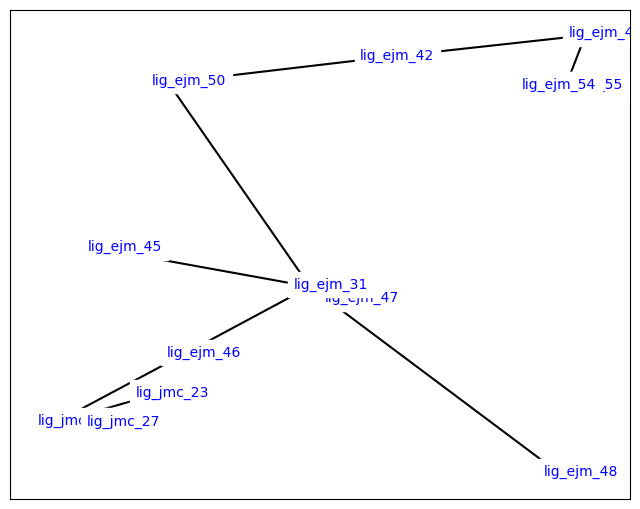

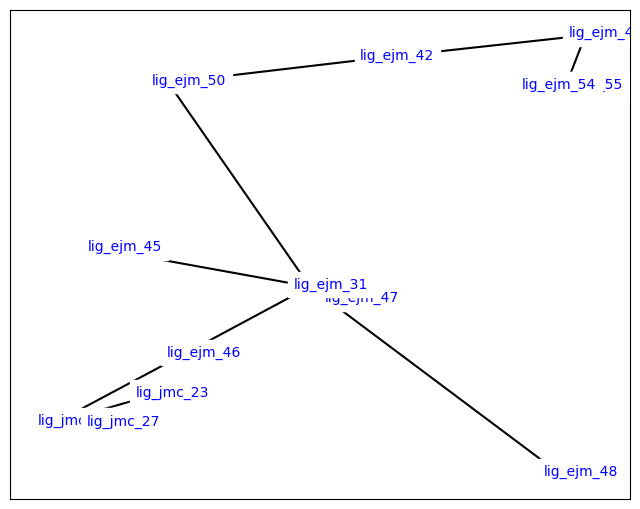

In [16]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

Since we are planning to perform relative binding free energy (RBFE) calculations, we'll define both *complex* and *solvent* variants for each `Transformation`:

In [17]:
for mapping in ligand_network.edges:
    print(mapping.componentA.name, mapping.componentB.name)

lig_ejm_46 lig_jmc_28
lig_ejm_31 lig_ejm_50
lig_ejm_42 lig_ejm_50
lig_ejm_31 lig_ejm_45
lig_ejm_31 lig_ejm_48
lig_ejm_55 lig_ejm_43
lig_jmc_27 lig_jmc_28
lig_jmc_23 lig_jmc_28
lig_ejm_46 lig_ejm_31
lig_ejm_42 lig_ejm_43
lig_ejm_47 lig_ejm_31
lig_ejm_54 lig_ejm_55


In [18]:
complexed_transformations = []
solvated_transformations = []

for mapping in ligand_network.edges:
    ligA_name = mapping.componentA.name
    ligB_name = mapping.componentB.name
    
    ligA = complexed[ligA_name]['ligand']
    ligB = complexed[ligB_name]['ligand']
        
    complexed_transformations.append(
        openfe.Transformation(stateA=complexed[ligA_name], 
                              stateB=complexed[ligB_name], 
                              mapping={'ligand': mapping},
                              protocol=protocol,
                              name=f"{complexed[ligA_name].name}->{complexed[ligB_name].name}")
    )
    solvated_transformations.append(
        openfe.Transformation(stateA=solvated[ligA_name], 
                              stateB=solvated[ligB_name], 
                              mapping={'ligand': mapping},
                              protocol=protocol,
                              name=f"{solvated[ligA_name].name}->{solvated[ligB_name].name}")
    )

### Create the `AlchemicalNetwork`

An `AlchemicalNetwork` is simply the combination of `ChemicalSystem`s (nodes) and `Transformation`s (directed edges) that we want to evaluate $\Delta G$s for. This data structure functions as a declaration of what you want to compute.

We'll finish here by creating an `AlchemicalNetwork` from the collection of objects we've built so far.

In [19]:
network = AlchemicalNetwork(edges=(solvated_transformations + complexed_transformations), 
                            nodes=(list(solvated.values()) + list(complexed.values())),
                            name="tyk2_relative_benchmark")
network

<AlchemicalNetwork-391c0eb68025cf4b83e4d706f189f745>

That's it! We simply toss in all `Transformation`s (edges) and `ChemicalSystem`s (nodes) we want included in this `AlchemicalNetwork`, and optionally give it a name that means something to us (it need not be unique, but can be used to query for network(s) later).

We could have chosen here to leave the `nodes` argument off, since every `ChemicalSystem` we included was already represented among the `edges`, but we show it here for completeness. In this way, it's possible to include `ChemicalSystem`s in the network that aren't connected via any `Transformation`s to others, though in practice there isn't much utility in this.

## Submitting an `AlchemicalNetwork` to `alchemiscale`

In [24]:
from alchemiscale import AlchemiscaleClient, Scope, ScopedKey
from getpass import getpass

In [25]:
identity_key = getpass()

 ········


In [26]:
asc = AlchemiscaleClient('https://api.alchemiscale.org', 'ddotson', identity_key)
asc

AlchemiscaleClient('https://api.alchemiscale.org')

In [27]:
asc.list_scopes()

[<Scope('*-*-*')>]

In [28]:
asc.query_networks(scope=Scope('ddotson'))

[<ScopedKey('AlchemicalNetwork-689ac3d31af47ccd4379f3742f81f400-ddotson-v0_1_2-test_small_tyk2')>]

`AlchemicalNetwork`s and the objects associated with them live in a *specific* `Scope`. Because my user identity is able to use any `Scope` from the above (`'*-*-*'`), I can choose whatever I want. `AlchemicalNetwork`s submitted to the same `Scope` will share `Transformation`s they have in common, along with results for those `Transformation`s; `AlchemicalNetwork`s in different `Scope`s will share nothing.

How you choose to use the `Scope`s you have access to is entirely up to you. I'll choose this is my `Scope` for this network:

In [29]:
scope = Scope('ddotson', 'tyk2', 'demo')

And then we'll submit the `AlchemicalNetwork` to that `Scope` with:

In [30]:
an_sk = asc.create_network(network, scope)

Output()

We get back a `ScopedKey` for the `AlchemicalNetwork:

In [31]:
an_sk

<ScopedKey('AlchemicalNetwork-391c0eb68025cf4b83e4d706f189f745-ddotson-tyk2-demo')>

This uniquely identifies the `AlchemicalNetwork` in the database, and allows us to perform operations later on it. We can get the `ScopedKey`s for all `AlchemicalNetwork`s that exist in `Scope`s accessible to us with:

In [34]:
asc.query_networks(scope=Scope('ddotson'))

[<ScopedKey('AlchemicalNetwork-391c0eb68025cf4b83e4d706f189f745-ddotson-tyk2-demo')>,
 <ScopedKey('AlchemicalNetwork-689ac3d31af47ccd4379f3742f81f400-ddotson-v0_1_2-test_small_tyk2')>]

We can likewise retrieve an `AlchemicalNetwork` that we previously submitted with:

In [35]:
network_again = asc.get_network(an_sk)

Output()

## Executing `Transformation`s by creating and actioning `Task`s

Submitting an `AlchemicalNetwork` with `create_network` only defines it on the server; it does not initiate any calculations. For this, we need to create and action `Task`s.

To obtain a free energy estimate $\Delta G$ for each `Transformation` in the `AlchemicalNetwork`, we'll create a `Task` for each one:

In [36]:
tasks = []
for tf_sk in asc.get_network_transformations(an_sk):
    tasks.extend(asc.create_tasks(tf_sk, count=1))

tasks

[<ScopedKey('Task-2086006a0f4440288d0efe1c3c2ff322-ddotson-tyk2-demo')>,
 <ScopedKey('Task-76b040461cef43cda7d655722e32f3ae-ddotson-tyk2-demo')>,
 <ScopedKey('Task-bd454eb3d986410cb7117419a453ff26-ddotson-tyk2-demo')>,
 <ScopedKey('Task-347b659304ec431fa6297f8a1601bd28-ddotson-tyk2-demo')>,
 <ScopedKey('Task-a164f0cef7514a0db760b36a981663e2-ddotson-tyk2-demo')>,
 <ScopedKey('Task-558e5c225d234dd6b48a7a50af9d2b86-ddotson-tyk2-demo')>,
 <ScopedKey('Task-eaa4951a328241809ade13790af28dba-ddotson-tyk2-demo')>,
 <ScopedKey('Task-a9c89d3284f44474ad7eb3eff7abbe78-ddotson-tyk2-demo')>,
 <ScopedKey('Task-15c362b475d64e82ba7e462eeb002b80-ddotson-tyk2-demo')>,
 <ScopedKey('Task-dc5dd38945ea4271b0f62e3dbce8ecf2-ddotson-tyk2-demo')>,
 <ScopedKey('Task-c8b90e227dfa4a6eb6fdafe1e95ac132-ddotson-tyk2-demo')>,
 <ScopedKey('Task-db244232f6ad4582971ad23029e698fd-ddotson-tyk2-demo')>,
 <ScopedKey('Task-ea7274e03a0f4917aaed6cfb60ec7ee9-ddotson-tyk2-demo')>,
 <ScopedKey('Task-ef5535569d464153b7dccbbd3b9b34f9-

Now checking the `AlchemicalNetwork` status, we see 24 `Task`s `'waiting'`, 1 for each `Transformation`:

In [37]:
asc.get_network_status(an_sk)

AlchemicalNetwork-391c0eb68025cf4b83e4d706f189f745-ddotson-tyk2-demo                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ status                                                           ┃                                        count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ complete                                                         │                                            0 │
│ running                                                          │                                            0 │
│ waiting                                                          │                                           24 │
│ error                                                            │                                            0 │
│ invalid                                                          │                                            0 │
│ deleted                                                          │                                            0 │
└──────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────┘

{'waiting': 24}

But there is one more step: `Task`s must also be *actioned* on the `AlchemicalNetwork` in order to be picked up by compute services:

In [38]:
asc.action_tasks(tasks, an_sk)

[<ScopedKey('Task-2086006a0f4440288d0efe1c3c2ff322-ddotson-tyk2-demo')>,
 <ScopedKey('Task-76b040461cef43cda7d655722e32f3ae-ddotson-tyk2-demo')>,
 <ScopedKey('Task-bd454eb3d986410cb7117419a453ff26-ddotson-tyk2-demo')>,
 <ScopedKey('Task-347b659304ec431fa6297f8a1601bd28-ddotson-tyk2-demo')>,
 <ScopedKey('Task-a164f0cef7514a0db760b36a981663e2-ddotson-tyk2-demo')>,
 <ScopedKey('Task-558e5c225d234dd6b48a7a50af9d2b86-ddotson-tyk2-demo')>,
 <ScopedKey('Task-eaa4951a328241809ade13790af28dba-ddotson-tyk2-demo')>,
 <ScopedKey('Task-a9c89d3284f44474ad7eb3eff7abbe78-ddotson-tyk2-demo')>,
 <ScopedKey('Task-15c362b475d64e82ba7e462eeb002b80-ddotson-tyk2-demo')>,
 <ScopedKey('Task-dc5dd38945ea4271b0f62e3dbce8ecf2-ddotson-tyk2-demo')>,
 <ScopedKey('Task-c8b90e227dfa4a6eb6fdafe1e95ac132-ddotson-tyk2-demo')>,
 <ScopedKey('Task-db244232f6ad4582971ad23029e698fd-ddotson-tyk2-demo')>,
 <ScopedKey('Task-ea7274e03a0f4917aaed6cfb60ec7ee9-ddotson-tyk2-demo')>,
 <ScopedKey('Task-ef5535569d464153b7dccbbd3b9b34f9-

The reason for this extra step is that a given `Transformation` may be a member of *multiple* `AlchemicalNetwork`s in its `Scope`. Computational effort is independently allocated on each `AlchemicalNetwork` through its *actioned* `Task`s, and these can differ between `AlchemicalNetwork`s in the same `Scope`. In the future, automated `Strategy`s will operate on individual `AlchemicalNetwork`s, and this ability to independently choose where to apply effort is critical for this.

After *actioning* our `Task`s, we can see that some have been picked up and are now `'running'`:

In [43]:
asc.get_network_status(an_sk)

AlchemicalNetwork-391c0eb68025cf4b83e4d706f189f745-ddotson-tyk2-demo                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ status                                                           ┃                                        count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ complete                                                         │                                            0 │
│ running                                                          │                                           15 │
│ waiting                                                          │                                            9 │
│ error                                                            │                                            0 │
│ invalid                                                          │                                            0 │
│ deleted                                                          │                                            0 │
└──────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────┘

{'waiting': 9, 'running': 15}

Later on, some are now `'complete'`:

In [52]:
asc.get_network_status(an_sk)

AlchemicalNetwork-391c0eb68025cf4b83e4d706f189f745-ddotson-tyk2-demo                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ status                                                           ┃                                        count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ complete                                                         │                                            0 │
│ running                                                          │                                           24 │
│ waiting                                                          │                                            0 │
│ error                                                            │                                            0 │
│ invalid                                                          │                                            0 │
│ deleted                                                          │                                            0 │
└──────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────┘

{'running': 24}

In [171]:
asc.get_network_status(an_sk)

AlchemicalNetwork-391c0eb68025cf4b83e4d706f189f745-ddotson-tyk2-demo                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ status                                                           ┃                                        count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ complete                                                         │                                           12 │
│ running                                                          │                                           12 │
│ waiting                                                          │                                            0 │
│ error                                                            │                                            0 │
│ invalid                                                          │                                            0 │
│ deleted                                                          │                                            0 │
└──────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────┘

{'complete': 12, 'running': 12}

### Dealing with errors

Inevitably, some of your `Task`s will encounter problems in execution, either random or systematic errors. When this happens, the `Task` status will be set to `'error'`. To illustrate this, we'll look at an `AlchemicalNetwork` with some failures:

In [65]:
failed_tasks = asc.query_tasks(scope=Scope('ddotson'), status='error')

In [66]:
an2_sk = asc.get_task_networks(failed_tasks[0])[0]
an2_sk

<ScopedKey('AlchemicalNetwork-391c0eb68025cf4b83e4d706f189f745-ddotson-tyk2-demo')>

We'll get all the `Task`s in this `AlchemicalNetwork` with status `'error'`:

In [67]:
failed_tasks = asc.get_network_tasks(an2_sk, status='error')
failed_tasks

[<ScopedKey('Task-ea7274e03a0f4917aaed6cfb60ec7ee9-ddotson-tyk2-demo')>]

We'll choose one, and get all the failed results for it:

In [68]:
failures = asc.get_task_failures(failed_tasks[0])
failures

Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-be3971fa5275fae3d0767ef387e4f673-ddotson-tyk2-demo/failures/ProtocolDAGResult-121caad10443c93c3a6cdad2618dbde5-ddotson-tyk2-demo "HTTP/1.1 200 OK"


[<ProtocolDAGResult-121caad10443c93c3a6cdad2618dbde5>]

Each of these is a `ProtocolDAGResult`, but with at least one `ProtocolUnitFailure`:

In [69]:
failures[0]

<ProtocolDAGResult-121caad10443c93c3a6cdad2618dbde5>

In [70]:
failures[0].protocol_unit_failures

[ProtocolUnitFailure(lig_ejm_46 to lig_ejm_31 repeat 0 generation 0)]

We can introspect the `traceback` on any of the `ProtocolUnitFailure`s present in the `ProtocolDAGResult` to understand what went wrong here:

In [71]:
print(failures[0].protocol_unit_failures[0].traceback)

Traceback (most recent call last):
  File "/lila/home/dotson/mambaforge/envs/alchemiscale-compute-ddotson-v0.1.3-2023.07.07/lib/python3.10/site-packages/openmmtools/multistate/multistatesampler.py", line 1328, in _propagate_replica
    mcmc_move.apply(thermodynamic_state, sampler_state, context_cache=self.sampler_context_cache)
  File "/lila/home/dotson/mambaforge/envs/alchemiscale-compute-ddotson-v0.1.3-2023.07.07/lib/python3.10/site-packages/openmmtools/mcmc.py", line 1151, in apply
    super(LangevinDynamicsMove, self).apply(thermodynamic_state, sampler_state,
  File "/lila/home/dotson/mambaforge/envs/alchemiscale-compute-ddotson-v0.1.3-2023.07.07/lib/python3.10/site-packages/openmmtools/mcmc.py", line 755, in apply
    raise IntegratorMoveError(err_msg, self, context)
openmmtools.mcmc.IntegratorMoveError: Potential energy is NaN after 20 attempts of integration with move LangevinDynamicsMove

During handling of the above exception, another exception occurred:

Traceback (most recen

In this case, it like it may be a random error that may clear if we re-run it.

If we wish to re-run an `'error'`ed `Task`, we can do so by setting its status back to `'waiting'`:

In [ ]:
# asc.set_tasks_status(failed_tasks, 'waiting')

## Gathering and analyzing results

We can gather results for each `Transformation` with:

In [54]:
results = dict()
for tf_sk in asc.get_network_transformations(an_sk):
    results[str(tf_sk)] = asc.get_transformation_results(tf_sk)

Output()

Output()

Output()

/home/david/Projects/action/alchemiscale-dev/testsite/user-instructions/alchemiscale/alchemiscale/interface/client.py:881: RuntimeWarning: coroutine 'use_session.<locals>._wrapper' was never awaited
  return asyncio.run(async_request(self))


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [55]:
results

{'Transformation-3bde3c547da7c4db25af92e94f34efce-ddotson-tyk2-demo': None,
 'Transformation-3d1c7ab3c70341bc88fc91112689a648-ddotson-tyk2-demo': None,
 'Transformation-333a2629c325b4f257b416c2431d9132-ddotson-tyk2-demo': None,
 'Transformation-086a259a37b0f93979cc23dc31344aa8-ddotson-tyk2-demo': None,
 'Transformation-553107db824ee8a99f30fb42cbe5798c-ddotson-tyk2-demo': None,
 'Transformation-08f4c68a8e178d698e59cc1a366e3415-ddotson-tyk2-demo': None,
 'Transformation-c244dffbafa7e4e95ff4c0a03a54888b-ddotson-tyk2-demo': None,
 'Transformation-7080ba2b294fbb443f7c8fd0432523b8-ddotson-tyk2-demo': None,
 'Transformation-2168cd5e6257debd9e31a7dea8f865db-ddotson-tyk2-demo': None,
 'Transformation-6fedaff17af81e8f8cd903ff54f4fa43-ddotson-tyk2-demo': None,
 'Transformation-058b41226978833e875145eca60fa44d-ddotson-tyk2-demo': None,
 'Transformation-a34291c782001508c20b0f8fbd8e8768-ddotson-tyk2-demo': None,
 'Transformation-be3971fa5275fae3d0767ef387e4f673-ddotson-tyk2-demo': None,
 'Transforma

In [56]:
results['Transformation-058b41226978833e875145eca60fa44d-ddotson-tyk2-demo'].get_estimate()

type: 'NoneType' object has no attribute 'get_estimate'

In [57]:
results['Transformation-058b41226978833e875145eca60fa44d-ddotson-tyk2-demo'].get_uncertainty()

type: 'NoneType' object has no attribute 'get_uncertainty'

In this case, we have only a single `ProtocolDAGResult` for each `Transformation` (since we created and actioned only 1 `Task` for each), and so the uncertainty given for this `ProtocolResult` is 0.0. The `RelativeHybridTopologyProtocol` combines `ProtocolDAGResult` values statistically, reducing the uncertainty but not increasing convergence with additional `Task`s

By contrast other `Protocol`s, such as the `perses` `NonEquilibriumCyclingProtocol`, will improve convergence with more `Task`s on a given `Transformation`; in the case of the `NonEquilibriumCyclingProtocol`, the non-equilibrium work values for each `ProtocolDAGResult` are combined together and fed to `BAR` to produce a single estimate with its own uncertainty.

Let's create and action 2 additional `Task`s for each `Transformation`:

In [58]:
tasks = []
for tf_sk in asc.get_network_transformations(an_sk):
    tasks.extend(asc.create_tasks(tf_sk, count=2))

asc.action_tasks(tasks, an_sk)

[<ScopedKey('Task-c3e9b3eb05ee42f4a4b5707c926e50e6-ddotson-tyk2-demo')>,
 <ScopedKey('Task-cfe6f9990ad945169e921025127a88a8-ddotson-tyk2-demo')>,
 <ScopedKey('Task-524f72e1c0e74e0d8ca7a01c30f1aad1-ddotson-tyk2-demo')>,
 <ScopedKey('Task-777c84bc65944a9a9801469812d1678c-ddotson-tyk2-demo')>,
 <ScopedKey('Task-925408217d364e7db939d12bb11a4d86-ddotson-tyk2-demo')>,
 <ScopedKey('Task-12faee45bfc04901ac1025dbde88eee7-ddotson-tyk2-demo')>,
 <ScopedKey('Task-36b153686a6b40d696c1c157cef8183e-ddotson-tyk2-demo')>,
 <ScopedKey('Task-d3c6125eb386459db42e6f7282c93d4e-ddotson-tyk2-demo')>,
 <ScopedKey('Task-e25628e703344d53b8ccef6788fc5600-ddotson-tyk2-demo')>,
 <ScopedKey('Task-6a70fe191bfd473685d8a4b20e1ae6c0-ddotson-tyk2-demo')>,
 <ScopedKey('Task-2bec6ac3ef4f409793521819f440cc41-ddotson-tyk2-demo')>,
 <ScopedKey('Task-f6a8d61822584b019d0e7b8931982c75-ddotson-tyk2-demo')>,
 <ScopedKey('Task-df47335dc8fa4d86a29d0d760aff39a8-ddotson-tyk2-demo')>,
 <ScopedKey('Task-295696c8358e470eade7268e5587c02f-

In [75]:
asc.get_network_status(an_sk)

AlchemicalNetwork-391c0eb68025cf4b83e4d706f189f745-ddotson-tyk2-demo                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ status                                                           ┃                                        count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ complete                                                         │                                           19 │
│ running                                                          │                                           48 │
│ waiting                                                          │                                            0 │
│ error                                                            │                                            5 │
│ invalid                                                          │                                            0 │
│ deleted                                                          │                                            0 │
└──────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────┘

{'complete': 19, 'running': 48, 'error': 5}

In [76]:
asc.get_network_tasks(an_sk, status='error')

[<ScopedKey('Task-925408217d364e7db939d12bb11a4d86-ddotson-tyk2-demo')>,
 <ScopedKey('Task-f6a8d61822584b019d0e7b8931982c75-ddotson-tyk2-demo')>,
 <ScopedKey('Task-2bec6ac3ef4f409793521819f440cc41-ddotson-tyk2-demo')>,
 <ScopedKey('Task-ea7274e03a0f4917aaed6cfb60ec7ee9-ddotson-tyk2-demo')>,
 <ScopedKey('Task-872b43742ada494aa84f37078b5b44ab-ddotson-tyk2-demo')>]

In [78]:
print(asc.get_task_failures(asc.get_network_tasks(an_sk, status='error')[0])[0].protocol_unit_failures[0].traceback)

Output()

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/gufe/protocols/protocolunit.py", line 319, in execute
    outputs = self._execute(context, **inputs)
  File "/opt/conda/lib/python3.10/site-packages/openfe/protocols/openmm_rfe/equil_rfe_methods.py", line 684, in _execute
    outputs = self.run(scratch_basepath=ctx.scratch,
  File "/opt/conda/lib/python3.10/site-packages/openfe/protocols/openmm_rfe/equil_rfe_methods.py", line 593, in run
    sampler.setup(
  File "/opt/conda/lib/python3.10/site-packages/openfe/protocols/openmm_rfe/_rfe_utils/multistate.py", line 121, in setup
    minimize(compound_thermostate_copy, sampler_state,
  File "/opt/conda/lib/python3.10/site-packages/openfe/protocols/openmm_rfe/_rfe_utils/multistate.py", line 295, in minimize
    context, integrator = dummy_cache.get_context(
  File "/opt/conda/lib/python3.10/site-packages/openmmtools/cache.py", line 770, in get_context
    context = thermodynamic_state.create_context(integrato

In [222]:
asc.set_tasks_status(asc.get_network_tasks(an_sk, status='error'), 'waiting')

INFO:	HTTP Request: POST http://api.alchemiscale.internal/bulk/tasks/status/set "HTTP/1.1 200 OK"


[<ScopedKey('Task-7a1996f4f1ad475280675e7c3779177f-ddotson-tyk2-demo')>,
 <ScopedKey('Task-6eb1962189f344a99842fa03e7deee39-ddotson-tyk2-demo')>]

In [86]:
asc.get_network_status(an_sk)

AlchemicalNetwork-391c0eb68025cf4b83e4d706f189f745-ddotson-tyk2-demo                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ status                                                           ┃                                        count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ complete                                                         │                                           66 │
│ running                                                          │                                            1 │
│ waiting                                                          │                                            0 │
│ error                                                            │                                            5 │
│ invalid                                                          │                                            0 │
│ deleted                                                          │                                            0 │
└──────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────┘

{'complete': 66, 'error': 5, 'running': 1}

In [87]:
results = dict()
for tf_sk in asc.get_network_transformations(an_sk):
    results[str(tf_sk)] = asc.get_transformation_results(tf_sk)

Output()

Output()

Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-333a2629c325b4f257b416c2431d9132-ddotson-tyk2-demo/results/ProtocolDAGResult-806f698909b750a3698b4d6adb6fec55-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-086a259a37b0f93979cc23dc31344aa8-ddotson-tyk2-demo/results/ProtocolDAGResult-689c3d9634662f7b1c203cb5a03a4b2d-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-086a259a37b0f93979cc23dc31344aa8-ddotson-tyk2-demo/results/ProtocolDAGResult-838875f30b3819eee3dbdd9dbd6ffc52-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-086a259a37b0f93979cc23dc31344aa8-ddotson-tyk2-demo/results/ProtocolDAGResult-71c63973b6d4371d32e96d7153a309bd-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-553107db824ee8a99f30fb42cbe5798c-ddotson-tyk2-demo/results/ProtocolDAGResult-23b43e03357467d675baec445e575b25-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-553107db824ee8a99f30fb42cbe5798c-ddotson-tyk2-demo/results/ProtocolDAGResult-4d8568c2571c2bcc7b450cf195ad73cb-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-c244dffbafa7e4e95ff4c0a03a54888b-ddotson-tyk2-demo/results/ProtocolDAGResult-39cff7743b37eff4d8c0b1f35ff2fd72-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-c244dffbafa7e4e95ff4c0a03a54888b-ddotson-tyk2-demo/results/ProtocolDAGResult-108f3d64858a27ea120f319e51f59ca8-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-c244dffbafa7e4e95ff4c0a03a54888b-ddotson-tyk2-demo/results/ProtocolDAGResult-3a5f5eacae033a67a0a8055091da5524-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-7080ba2b294fbb443f7c8fd0432523b8-ddotson-tyk2-demo/results/ProtocolDAGResult-9cde6e9d00195d6456a9680383b61944-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-2168cd5e6257debd9e31a7dea8f865db-ddotson-tyk2-demo/results/ProtocolDAGResult-91f354893da6a496472afcd522b9a3e9-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-058b41226978833e875145eca60fa44d-ddotson-tyk2-demo/results/ProtocolDAGResult-573acdaa101d5bd8a8159fc1627824dc-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-058b41226978833e875145eca60fa44d-ddotson-tyk2-demo/results/ProtocolDAGResult-4bb4e396d356995fa1b4ad8dcf21a97a-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-058b41226978833e875145eca60fa44d-ddotson-tyk2-demo/results/ProtocolDAGResult-a6703908d949893b0daaaeeea8e1d934-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-a34291c782001508c20b0f8fbd8e8768-ddotson-tyk2-demo/results/ProtocolDAGResult-b2dc2e1f35e0703a344c874f757f30ee-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-a34291c782001508c20b0f8fbd8e8768-ddotson-tyk2-demo/results/ProtocolDAGResult-bfc621afbaa5be2ff984ee5f1ae11967-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-a34291c782001508c20b0f8fbd8e8768-ddotson-tyk2-demo/results/ProtocolDAGResult-17b42d9eae108b31024f618da7e14d5d-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-be3971fa5275fae3d0767ef387e4f673-ddotson-tyk2-demo/results/ProtocolDAGResult-d5f4b9a5cf5daf45a32ec0c8b3469f6a-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-be3971fa5275fae3d0767ef387e4f673-ddotson-tyk2-demo/results/ProtocolDAGResult-06817c2336f669d031bb6ab451312cf0-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-c824272678b20bb10b0b3ed82a75cba7-ddotson-tyk2-demo/results/ProtocolDAGResult-e6b9f80790a921b5ecc0022484bba911-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-c824272678b20bb10b0b3ed82a75cba7-ddotson-tyk2-demo/results/ProtocolDAGResult-2e1d2a545b292c64587bd0ef53e18bcf-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-72f58e6ef2cc85e52de765b797fb935b-ddotson-tyk2-demo/results/ProtocolDAGResult-44c51300dddbc58861222b8343c72774-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-d5634110bde446e3c0135a213ca126be-ddotson-tyk2-demo/results/ProtocolDAGResult-1627122ffa92a50e154f7db8b3caeadb-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-d5634110bde446e3c0135a213ca126be-ddotson-tyk2-demo/results/ProtocolDAGResult-e39c92f942f2a1a795b738c6fe29b16e-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-d5634110bde446e3c0135a213ca126be-ddotson-tyk2-demo/results/ProtocolDAGResult-a5bcdbbc852823d04de475c27f33c832-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-cfc64db96341e6c6fe78b31bc45086fe-ddotson-tyk2-demo/results/ProtocolDAGResult-081bfb04f824b538e4ecd5daff692faf-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-cfc64db96341e6c6fe78b31bc45086fe-ddotson-tyk2-demo/results/ProtocolDAGResult-903c857a775888bd8693976df292f5ac-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-cfc64db96341e6c6fe78b31bc45086fe-ddotson-tyk2-demo/results/ProtocolDAGResult-40be69c2a52a1fff96353511e489e49e-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-f549eb13fa5c5aa43a4b0581509ec17b-ddotson-tyk2-demo/results/ProtocolDAGResult-5393e8b5fd6e4b062234258291d724e0-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-f549eb13fa5c5aa43a4b0581509ec17b-ddotson-tyk2-demo/results/ProtocolDAGResult-487095daa4814b1b785b89f140ced7ac-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-f549eb13fa5c5aa43a4b0581509ec17b-ddotson-tyk2-demo/results/ProtocolDAGResult-46fdcb21b5c585811fc03e85873aa407-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-22f055e336144e1192a54fc36b008761-ddotson-tyk2-demo/results/ProtocolDAGResult-0cb38d52a48a5ce429412971947b896c-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-22f055e336144e1192a54fc36b008761-ddotson-tyk2-demo/results/ProtocolDAGResult-56724873cffb00ae49c17e03774b6bec-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-22f055e336144e1192a54fc36b008761-ddotson-tyk2-demo/results/ProtocolDAGResult-5dc86bcb2bf22e7c9d50500e7fc8a773-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-954a54426ba12cd7f97b163692de84b3-ddotson-tyk2-demo/results/ProtocolDAGResult-f3835ff36ae36b0e042cd1709dcf1646-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-954a54426ba12cd7f97b163692de84b3-ddotson-tyk2-demo/results/ProtocolDAGResult-9be3d801460d0d3f43894be9a6b13a81-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-954a54426ba12cd7f97b163692de84b3-ddotson-tyk2-demo/results/ProtocolDAGResult-49ba06302be65d93e9455ec1f74c2eb4-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-43fcc3ea77628d04acffbfafaf7289f3-ddotson-tyk2-demo/results/ProtocolDAGResult-44bdc10aef9e37f9eb5d27742f7489a4-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-43fcc3ea77628d04acffbfafaf7289f3-ddotson-tyk2-demo/results/ProtocolDAGResult-358d1811d201b78dd855601bfbb7eae4-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-43fcc3ea77628d04acffbfafaf7289f3-ddotson-tyk2-demo/results/ProtocolDAGResult-923d97861e4beff65321d0a9683400a3-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-1ed12e0907b854bd0810ebb8bce91bbd-ddotson-tyk2-demo/results/ProtocolDAGResult-871d1ca2965604f051f4de148a6abe6e-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-1ed12e0907b854bd0810ebb8bce91bbd-ddotson-tyk2-demo/results/ProtocolDAGResult-157732f23bc402b303c94f43e8d1b741-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-1ed12e0907b854bd0810ebb8bce91bbd-ddotson-tyk2-demo/results/ProtocolDAGResult-ad8882627d0d073a6798470830735977-ddotson-tyk2-demo "HTTP/1.1 200 OK"


Output()

Output()

INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-1d104d98ba12a95e13d2e086f1839b51-ddotson-tyk2-demo/results/ProtocolDAGResult-94a7e451b8184f3ad82435aa844b4d20-ddotson-tyk2-demo "HTTP/1.1 200 OK"
INFO:	HTTP Request: GET https://api.alchemiscale.org/transformations/Transformation-1d104d98ba12a95e13d2e086f1839b51-ddotson-tyk2-demo/results/ProtocolDAGResult-b47a0c1f1a185c49fd0f47273b4cd26f-ddotson-tyk2-demo "HTTP/1.1 200 OK"


In [88]:
results

{'Transformation-3bde3c547da7c4db25af92e94f34efce-ddotson-tyk2-demo': <RelativeHybridTopologyProtocolResult-bf72eafe8b0d7564ccb95b232fddb38e>,
 'Transformation-3d1c7ab3c70341bc88fc91112689a648-ddotson-tyk2-demo': <RelativeHybridTopologyProtocolResult-9086a10bf1fdea0717c4c8b8fb460201>,
 'Transformation-333a2629c325b4f257b416c2431d9132-ddotson-tyk2-demo': <RelativeHybridTopologyProtocolResult-d30fa20b06330cacc7608a030a18d347>,
 'Transformation-086a259a37b0f93979cc23dc31344aa8-ddotson-tyk2-demo': <RelativeHybridTopologyProtocolResult-c6bbd02888eaee71cb463aaac6611e17>,
 'Transformation-553107db824ee8a99f30fb42cbe5798c-ddotson-tyk2-demo': <RelativeHybridTopologyProtocolResult-814a45e31997809a16f376e3e1823554>,
 'Transformation-08f4c68a8e178d698e59cc1a366e3415-ddotson-tyk2-demo': <RelativeHybridTopologyProtocolResult-743b1ae43bc1d295e9c02efcb57f192a>,
 'Transformation-c244dffbafa7e4e95ff4c0a03a54888b-ddotson-tyk2-demo': <RelativeHybridTopologyProtocolResult-4225282c756a0bd7479fba9b59835b16>,

## Advanced example: comparing results to experimental values with `cinnabar`

Credit: Irfan Alibay

Source notebook: https://github.com/IAlibay/alchemiscale-utilities/blob/main/notebooks/TYK2_MST/Alchemiscale_submit_and_analyze.ipynb

We can gather up results for each `Transformation` as above and put into a form suitable for use with `cinnabar`. This will allow us to compare to experimental values for the binding free energies of these ligands. We use experimental values listed in:

In [89]:
%cat ligands.yml

lig_ejm_31:
  measurement:
    comment: Table 4, entry 31
    doi: 10.1016/j.ejmech.2013.03.070
    error: 0.029
    type: ki
    unit: uM
    value: 0.096
  name: lig_ejm_31
  smiles: '[H]c1c(c(c(c(c1[H])Cl)C(=O)N([H])c2c(c(nc(c2[H])N([H])C(=O)C([H])([H])[H])[H])[H])Cl)[H]'
lig_ejm_42:
  measurement:
    comment: Table 4, entry 42
    doi: 10.1016/j.ejmech.2013.03.070
    error: 0.019
    type: ki
    unit: uM
    value: 0.064
  name: lig_ejm_42
  smiles: '[H]c1c(c(c(c(c1[H])Cl)C(=O)N([H])c2c(c(nc(c2[H])N([H])C(=O)C([H])([H])C([H])([H])[H])[H])[H])Cl)[H]'
lig_ejm_43:
  measurement:
    comment: Table 4, entry 43
    doi: 10.1016/j.ejmech.2013.03.070
    error: 0.25
    type: ki
    unit: uM
    value: 0.84
  name: lig_ejm_43
  smiles: '[H]c1c(c(c(c(c1[H])Cl)C(=O)N([H])c2c(c(nc(c2[H])N([H])C(=O)C([H])(C([H])([H])[H])C([H])([H])[H])[H])[H])Cl)[H]'
lig_ejm_45:
  measurement:
    comment: Table 4, entry 45
    doi: 10.1016/j.ejmech.2013.03.070
    error: 0.028
    type: ki
    unit: uM
  

In [90]:
from pathlib import Path

In [91]:
# Next we define a convenience method to check what type of transformation we are looking at
def _scan_components(system):
    comps = system.components.values()
    if any([isinstance(comp, openfe.ProteinComponent) for comp in comps]):
        return "complex"
    elif any([isinstance(comp, openfe.SolventComponent) for comp in comps]):
        return "solvent"
    else:
        return "vacuum"

In [93]:
# Next we create a results dictionary and scan our network edges to accumulate all
# the free energy results and their uncertainty
results_dir = Path('results')
results_dir.mkdir(parents=True, exist_ok=True)
results = dict()
for transformation in network.edges:
    sk = asc.get_scoped_key(transformation, scope)
    result = asc.get_transformation_results(sk)
    if result is None:
        continue
    runtype = _scan_components(transformation.stateA)
    mapping = transformation.mapping['ligand']
    nameA = mapping.componentA.name
    nameB = mapping.componentB.name

    # store in accumulator
    if f"{nameA}_{nameB}" in results.keys():
        results[f"{nameA}_{nameB}"][runtype] = result
    else:
        results[f"{nameA}_{nameB}"] = {runtype: result, 'molA': nameA, 'molB': nameB}

    # output individual results to a separate `.dat` file for future use
    filename = results_dir / f"{nameA}_{nameB}.{runtype}.results.dat"
    output = f"{result.get_estimate()},{result.get_uncertainty()}"

    with open(filename, 'w') as f:
        f.write(output)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

### Writing out a `cinnabar` input CSV file

Since this is a known benchmark system, we have experimental values for each of our ligands. We can combine them with our results to create a `cinnabar` input CSV file.

**Note: this will change very soon. We are in the process of refactoring the cinnabar API.**

In [94]:
# Here we create a dictionary of experimental values from an input protein-ligand benchmark ligands.yml

# First load the yaml data
import yaml

with open('ligands.yml') as stream:
    exp_data = yaml.safe_load(stream)

In [95]:
# Define a method for converting between Ki to estimated DG
from openff.units import unit
import math

def ki_to_dg(
    ki: unit.Quantity, uncertainty: unit.Quantity,
    temperature: unit.Quantity = 298.15 * unit.kelvin
) -> tuple[unit.Quantity, unit.Quantity]:
    """
    Convenience method to convert a Ki w/ a given uncertainty to an
    experimental estimate of the binding free energy.
    
    Parameters
    ----------
    ki : unit.Quantity
        Experimental Ki value (e.g. 5 * unit.nanomolar)
    uncertainty : unit.Quantity
        Experimental error. Note: returns 0 if =< 0 * unit.nanomolar.
    temperature : unit.Quantity
        Experimental temperature. Default: 298.15 * unit.kelvin.
        
    Returns
    -------
    DG : unit.Quantity
        Gibbs binding free energy.
    dDG : unit.Quantity
        Error in binding free energy.
    """
    if ki > 1e-15 * unit.nanomolar:
        DG = (unit.molar_gas_constant * temperature.to(unit.kelvin)
              * math.log(ki / unit.molar)).to(unit.kilocalorie_per_mole)
    else:
        raise ValueError("negative Ki values are not supported")
    if uncertainty > 0 * unit.molar:
        dDG = (unit.molar_gas_constant * temperature.to(unit.kelvin)
               * uncertainty / ki).to(unit.kilocalorie_per_mole)
    else:
        dDG = 0 * unit.kilocalorie_per_mole
        
    return DG, dDG

In [96]:
from openff.units import unit

exp_values = {}
for lig in exp_data:
    exp_units = unit(exp_data[lig]['measurement']['unit'])
    exp_values[lig] = {}
    DG, dDG = ki_to_dg(exp_data[lig]['measurement']['value'] * exp_units,
                       exp_data[lig]['measurement']['error'] * exp_units)
    exp_values[lig]['value'] = DG
    exp_values[lig]['error'] = dDG

In [97]:
import numpy as np

# write out the cinnabar input file
with open('cinnabar_input.csv', 'w') as f:
    f.write("# Experimental block\n")
    f.write("# Ligand, expt_DDG, expt_dDDG\n")
    for entry in exp_values:
        f.write(f"{entry},{exp_values[entry]['value'].m:.2f},{exp_values[entry]['error'].m:.2f}\n")
    f.write('\n')
    
    f.write('# Calculated block\n')
    f.write('# Ligand1,Ligand2,calc_DDG,calc_dDDG(MBAR),calc_dDDG(additional)\n')
    for entry in results:
        estimate = (results[entry]['complex'].get_estimate()
                    - results[entry]['solvent'].get_estimate())
        err = np.sqrt(results[entry]['complex'].get_uncertainty()**2
                      + results[entry]['solvent'].get_uncertainty()**2)
        molA = results[entry]['molA']
        molB = results[entry]['molB']
        f.write(f"{molA},{molB},{estimate.m:.2f},0,{err.m:.2f}\n")

### Plotting out results using `cinnabar` components

**Note: this is a non-standard use of `cinnabar`. The ability to use the API to directly return a plotting object will be fixed in the next release.**

In [100]:
import numpy as np
import matplotlib.pylab as plt
from cinnabar import plotting, wrangle, stats
%matplotlib inline

In [101]:
def feplot(csv, name):
    fe = wrangle.FEMap(csv)
    fe.generate_absolute_values()
    
    # data
    x_dG = np.asarray([node[1]["exp_DG"] for node in fe.graph.nodes(data=True)])
    y_dG = np.asarray([node[1]["calc_DG"] for node in fe.graph.nodes(data=True)])
    y_dG = y_dG - np.mean(y_dG) + np.mean(x_dG)
    xerr_dG = np.asarray([node[1]["exp_dDG"] for node in fe.graph.nodes(data=True)])
    yerr_dG = np.asarray([node[1]["calc_dDG"] for node in fe.graph.nodes(data=True)])
    x_ddG = np.asarray([x[2]["exp_DDG"] for x in fe.graph.edges(data=True)])
    y_ddG = np.asarray([x[2]["calc_DDG"] for x in fe.graph.edges(data=True)])
    xerr_ddG = np.asarray([x[2]["exp_dDDG"] for x in fe.graph.edges(data=True)])
    yerr_ddG = np.asarray([x[2]["calc_dDDG"] for x in fe.graph.edges(data=True)])

    # RBFE
    statistics = ["RMSE", "MUE"]
    stats_rbfe = {}
        
    for statistic in statistics:
        s = stats.bootstrap_statistic(x_ddG, y_ddG, xerr_ddG, yerr_ddG, statistic=statistic)
        stats_rbfe[statistic] = s

    textstr = '\t'.join((
        f"$RMSE$ = {stats_rbfe['RMSE']['mle']:.2f} [95%: {stats_rbfe['RMSE']['low']:.2f}, {stats_rbfe['RMSE']['high']:.2f}]",
        f"$MUE$ = {stats_rbfe['MUE']['mle']:.2f} [95%: {stats_rbfe['MUE']['low']:.2f}, {stats_rbfe['MUE']['high']:.2f}]"
    ))        
        
    color = np.abs(x_ddG - y_ddG)
    cm = plt.get_cmap('coolwarm')
    color = cm(color / 2.372)
    fig, ax = plt.subplots()
    ax.errorbar(x_ddG, y_ddG, xerr=xerr_ddG, yerr=yerr_ddG, color='black', linewidth=0.0, elinewidth=2.0, zorder=1)
    ax.scatter(x_ddG, y_ddG, color=color, s=50, marker='o', zorder=2)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

    ax.set_title(f'{name}\n', fontsize=24, pad=25)
    ax.set_xlabel(r'Experimental $\/\Delta \Delta G \/(kcal/mol)$', fontsize=22)
    ax.set_ylabel(r'Calculated $\/\Delta \Delta G \/(kcal/mol)$', fontsize=22)
    ax.set_xticks(np.arange(-4, 6,step=2.0))
    ax.set_yticks(np.arange(-4, 6,step=2.0))
    x = np.linspace(-4, 4, 100)
    ax.plot(x, x, linestyle='--', color='black', alpha=0.5)
    ax.fill_between(x, x+1, x-1, color='grey', alpha=0.2)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    fig.suptitle(textstr, fontsize=12)
    fig.savefig(f'{name}-RBFEs.png', dpi=600, bbox_inches="tight")
        
    # ABFE
    statistics=["RMSE", "MUE", "R2", "rho"]
        
    stats_abfe = {}
        
    for statistic in statistics:
        s = stats.bootstrap_statistic(x_dG, y_dG, xerr_dG, yerr_dG, statistic=statistic)
        stats_abfe[statistic] = s
    err_str = '\t'.join((
        f"$RMSE$ = {stats_abfe['RMSE']['mle']:.2f} [95%: {stats_abfe['RMSE']['low']:.2f}, {stats_abfe['RMSE']['high']:.2f}]",
        f"$MUE$ = {stats_abfe['MUE']['mle']:.2f} [95%: {stats_abfe['MUE']['low']:.2f}, {stats_abfe['MUE']['high']:.2f}]"
    ))
    corr_str = '\t'.join((
        f"$r$ = {stats_abfe['rho']['mle']:.2f} [95%: {stats_abfe['rho']['low']:.2f}, {stats_abfe['rho']['high']:.2f}]",
        f"$R^2$ = {stats_abfe['R2']['mle']:.2f} [95%: {stats_abfe['R2']['low']:.2f}, {stats_abfe['R2']['high']:.2f}]"
    ))
    textstr = '\n'.join((
        err_str,
        corr_str,
    ))
        
    color = np.abs(x_dG - y_dG)
    color = cm(color / 2.372)
    fig, ax = plt.subplots()
    ax.errorbar(x_dG, y_dG, xerr=xerr_dG, yerr=yerr_dG, color='black', linewidth=0.0, elinewidth=2.0, zorder=1)
    ax.scatter(x_dG, y_dG, color=color, s=50, marker='o', zorder=2)
    ax.set_xlim(-14, -6)
    ax.set_ylim(-14, -6)

    ax.set_title(f'{name}\n', fontsize=24, pad=25)
    ax.set_xlabel(r'Experimental $\/\Delta G \/(kcal/mol)$', fontsize=22)
    ax.set_ylabel(r'Calculated $\/\Delta G \/(kcal/mol)$', fontsize=22)
    ax.set_xticks(np.arange(-14, -4,step=2.0))
    ax.set_yticks(np.arange(-14, -4,step=2.0))
    x = np.linspace(-14, -6, 100)
    ax.plot(x, x, linestyle='--', color='black', alpha=0.5)
    ax.fill_between(x, x+1, x-1, color='grey', alpha=0.2)
        
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    fig.suptitle(textstr, fontsize=12)
    #fig.savefig(f'{name}-ABFEs.png', dpi=600, bbox_inches="tight")

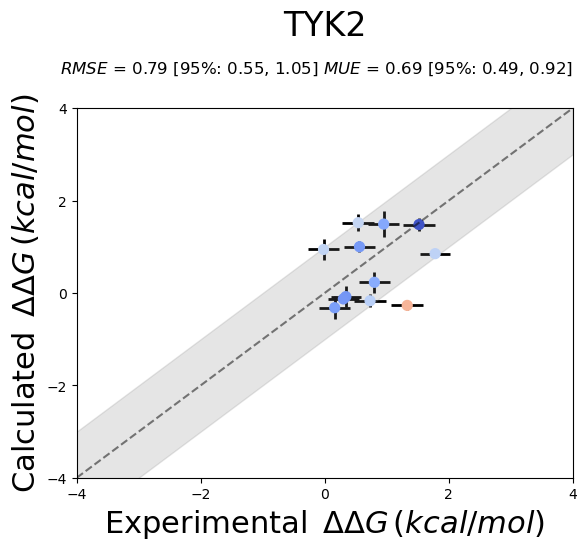

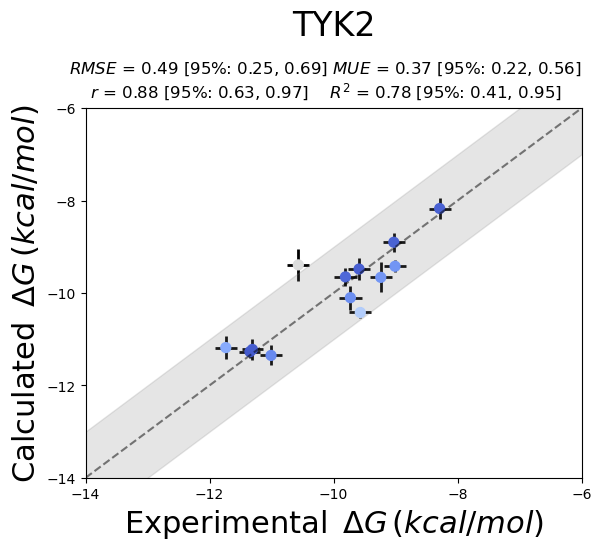

In [102]:
feplot('cinnabar_input.csv', 'TYK2')

In [103]:
an_sk

<ScopedKey('AlchemicalNetwork-391c0eb68025cf4b83e4d706f189f745-ddotson-tyk2-demo')>